In [1]:
import sys
from pathlib import Path

# Add the src directory to the Python path
sys.path.append(str(Path().resolve().parent / "src"))

# Import necessary libraries
import torch
import shap
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from ipywidgets import interact, FloatSlider

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import glob
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.transforms import v2
from config import MODEL_DIR, MODEL_NAME, DEVICE
from model.architecture_config import get_multimodal_cnn_model
from model.train import calculate_metrics
import config
from utils.dataset_loader import LandslideDataset

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [2]:
# load data into device
device = torch.device(config.DEVICE)

# Create dataset with data loaded into memory
print("Loading dataset into memory...")
dataset = LandslideDataset(
    image_dir=config.PROCESSED_TRAIN_IMAGE_DIR,
    csv_path=config.TRAIN_CSV_PATH,
    device=device
)

Loading dataset into memory...


Loading images: 100%|██████████| 3554/3554 [00:01<00:00, 2232.76it/s]

Total memory usage: 0.65 GB


In [3]:
# Load the first model checkpoints from the cross-validation folder
model_dir = MODEL_DIR / MODEL_NAME
model_path = glob.glob(str(model_dir / f"{MODEL_NAME}_*.pth"))[0]

print(f"Loading model from {model_path}")
#model = get_multimodal_cnn_model(fc_units=128, dropout=0.0, final_dropout=0.0).to(device)
checkpoint = torch.load(model_path, map_location=device, weights_only=False)
model = checkpoint['model'] # .load_state_dict(checkpoint['model_state_dict'])

targets = checkpoint["val_targets"]
y_preds = checkpoint["final_val_predictions"]

# load performance related information

Loading model from D:\Landslide-Image-Classification\models\fine_tune_BEN_RN18_V0\fine_tune_BEN_RN18_V0_0.pth


accuracy score: 0.9043600562587905
F1 score: 0.8671875
Confusion matrix
[[421  43]
 [ 25 222]]
model 1 AUC score: 0.9603256317185538
F1-optimal threshold:  0.53 F1:  0.8712871287128713


(0.9043600562587905,
 0.8987854251012146,
 0.8377358490566038,
 0.8671875,
 np.float64(0.53))

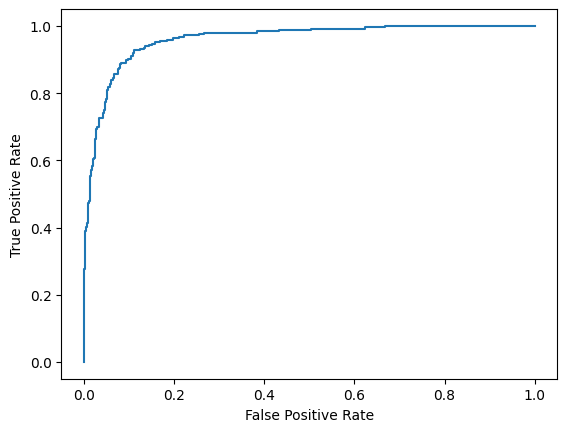

In [4]:
print(f'accuracy score: {checkpoint["val_accuracies"][-1]}')
print(f'F1 score: {checkpoint["val_f1s"][-1]}')
cf_mat = confusion_matrix(targets,  y_preds> 0.5)
print('Confusion matrix')
print(cf_mat)

plot_roc_curve(targets, y_preds)
print(f'model 1 AUC score: {roc_auc_score(targets, y_preds)}')

calculate_metrics(targets, y_preds, f1_optimal=True)

In [5]:
# extract mistakes
mistakes_bool = targets != (y_preds > 0.5)
mistakes_idx = checkpoint["val_idx"][mistakes_bool]
print("Number of miss-classified images: ", len(mistakes_idx))


# resize for BEN input:
dataset.transform = v2.Resize(size=120)

# Create subsets from the same dataset
train_subset = Subset(dataset, checkpoint["train_idx"])
error_subset = Subset(dataset, mistakes_idx)

# Load entire train subset as a single batch
train_images, train_targets = next(iter(DataLoader(
    train_subset,
    batch_size=200,
    shuffle=True,
    num_workers=0,
    generator=torch.Generator().manual_seed(config.SEED)
)))

# Load entire error subset as a single batch
error_images, error_targets = next(iter(DataLoader(
    error_subset,
    batch_size=len(error_subset),
    shuffle=False,
    num_workers=0
)))



Number of miss-classified images:  68


In [6]:
lora = model.pretrained_model.layer1[0].conv1.lora_up
lora.weight

Parameter containing:
tensor([[[[-2.4113e-03,  3.7437e-04,  8.6589e-03],
          [ 4.4536e-03,  8.4458e-03,  1.7531e-02],
          [-4.7807e-03, -9.8337e-04,  5.9897e-03]],

         [[-5.5961e-02, -5.4257e-02, -3.9761e-02],
          [-4.6278e-02, -4.4584e-02, -3.4291e-02],
          [-4.3188e-02, -4.6261e-02, -3.8513e-02]],

         [[ 1.7070e-03, -9.0204e-03, -2.7097e-02],
          [ 7.5715e-03, -1.0653e-02, -3.7489e-02],
          [ 4.2402e-03, -1.8537e-02, -4.9426e-02]],

         ...,

         [[-4.2574e-02, -3.1397e-02, -2.2585e-02],
          [-3.6700e-02, -2.3047e-02, -8.1404e-03],
          [-4.5221e-02, -2.8071e-02, -1.1459e-02]],

         [[ 5.5998e-02,  3.8701e-02,  3.4623e-02],
          [ 4.3078e-02,  2.2314e-02,  1.4192e-02],
          [ 4.1706e-02,  1.7909e-02,  8.9509e-03]],

         [[ 4.4561e-02,  3.3313e-02,  2.6584e-02],
          [ 4.0036e-02,  2.7858e-02,  1.8369e-02],
          [ 3.9364e-02,  2.4702e-02,  1.4414e-02]]],


        [[[ 1.0443e-02,  1.2222

In [7]:
# calculate SHAP values for each misclassified image
e = shap.DeepExplainer(model, train_images)
shap_values = e.shap_values(error_images, check_additivity=False)

RuntimeError: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.

interactive(children=(FloatSlider(value=1.0, description='SHAP transparency', max=1.0), Output()), _dom_classe…

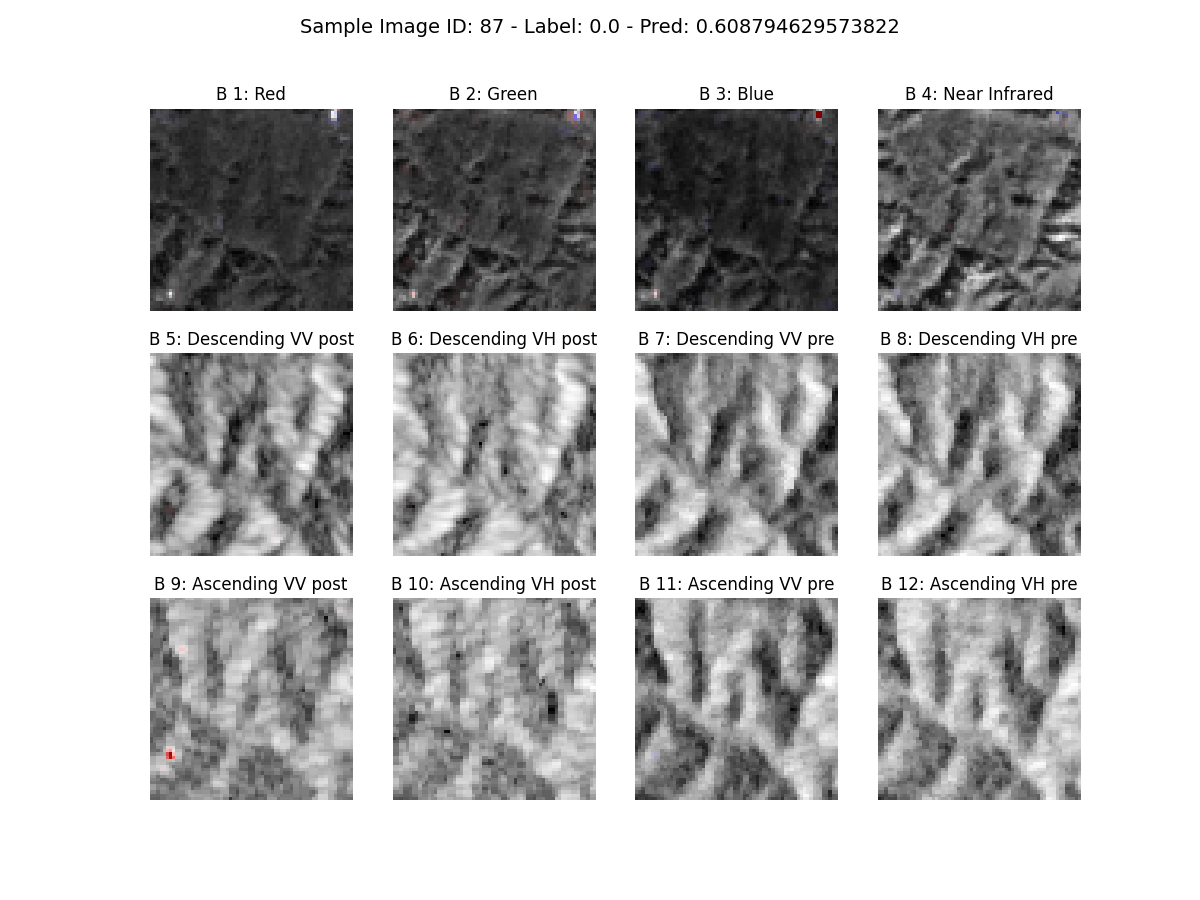

In [ ]:
%matplotlib widget

# Band descriptions
band_descriptions = [
    "Red", "Green", "Blue", "Near Infrared",
    "Descending VV post", "Descending VH post",
    "Descending VV pre", "Descending VH pre",
    "Ascending VV post", "Ascending VH post",
    "Ascending VV pre", "Ascending VH pre"
]

# SHAP visualization settings
vmin, vmax = -0.1, 0.1
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('seismic')

# Data prep (as before)
example_id = np.random.randint(len(error_images))
image = error_images[example_id]
shap_values_example = shap_values[example_id]
label = targets[mistakes_bool][example_id]
y_pred = y_preds[mistakes_bool][example_id]

# Precompute RGB channels
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle(f"Sample Image ID: {example_id} - Label: {label} - Pred: {y_pred}", fontsize=14)

rgba_overlays = []
overlay_images = []

for band in range(12):
    row, col = divmod(band, 4)
    
    # Background image
    axes[row, col].imshow(image[band].cpu().numpy(), cmap='gray')
    axes[row, col].set_title(f"B {band + 1}: {band_descriptions[band]}")
    axes[row, col].axis('off')
    
    # Precompute SHAP normalized and RGB values
    shap_band = shap_values_example[band, :, :, 0]
    shap_norm = norm(shap_band)
    rgba = cmap(shap_norm)
    
    # Store RGB and |shap| for alpha modulation
    rgb = rgba[..., :3]  # shape (H, W, 3)
    abs_shap = np.clip(np.abs(shap_band) / vmax, 0, 1)  # shape (H, W)
    
    # Compose RGBA for initial alpha
    initial_alpha = 1
    rgba_full = np.dstack((rgb, initial_alpha * abs_shap))
    
    # Plot and store overlay
    overlay = axes[row, col].imshow(rgba_full)
    rgba_overlays.append((rgb, abs_shap))  # keep for dynamic update
    overlay_images.append(overlay)

# Update only alpha channel
def update(alpha=1):
    for i in range(12):
        rgb, abs_shap = rgba_overlays[i]
        new_rgba = np.dstack((rgb, alpha * abs_shap))
        overlay_images[i].set_data(new_rgba)
    fig.canvas.draw_idle()

# Create interactive slider
interact(update, alpha=FloatSlider(value=1, min=0.0, max=1.0, step=0.1, description="SHAP transparency"));


In [ ]:
# extract correct labeled
correct_bool = targets == (y_preds > 0.5)
correct_idx = checkpoint["val_idx"][correct_bool][:50]


# Create subsets from the same dataset
train_subset = Subset(dataset, checkpoint["train_idx"])
correct_subset = Subset(dataset, correct_idx)

# Load entire train subset as a single batch
train_images, train_targets = next(iter(DataLoader(
    train_subset,
    batch_size=200,
    shuffle=True,
    num_workers=0,
    generator=torch.Generator().manual_seed(config.SEED)
)))

# Load entire error subset as a single batch
correct_images, correct_targets = next(iter(DataLoader(
    correct_subset,
    batch_size=len(correct_subset),
    shuffle=False,
    num_workers=0
)))

# calculate SHAP values for each misclassified image
e = shap.DeepExplainer(model, train_images)
correct_shap_values = e.shap_values(correct_images, check_additivity=False)

interactive(children=(FloatSlider(value=1.0, description='SHAP transparency', max=1.0), Output()), _dom_classe…

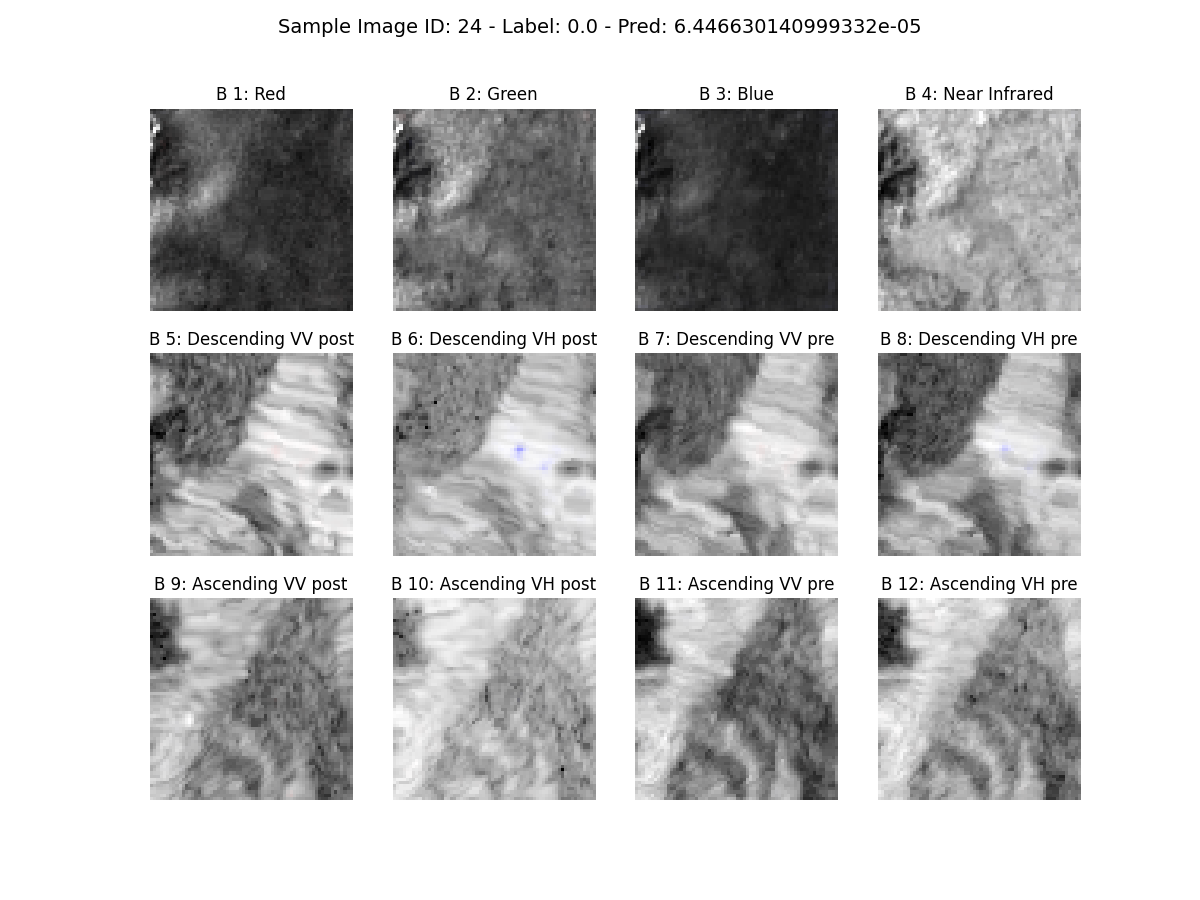

In [ ]:
%matplotlib widget

# Band descriptions
band_descriptions = [
    "Red", "Green", "Blue", "Near Infrared",
    "Descending VV post", "Descending VH post",
    "Descending VV pre", "Descending VH pre",
    "Ascending VV post", "Ascending VH post",
    "Ascending VV pre", "Ascending VH pre"
]

# SHAP visualization settings
vmin, vmax = -0.1, 0.1
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('seismic')

# Data prep (as before)
example_id = np.random.randint(len(correct_images))
image = correct_images[example_id]
shap_values_example = correct_shap_values[example_id]
label = targets[correct_bool][example_id]
y_pred = y_preds[correct_bool][example_id]

# Precompute RGB channels
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle(f"Sample Image ID: {example_id} - Label: {label} - Pred: {y_pred}", fontsize=14)

rgba_overlays = []
overlay_images = []

for band in range(12):
    row, col = divmod(band, 4)
    
    # Background image
    axes[row, col].imshow(image[band].cpu().numpy(), cmap='gray')
    axes[row, col].set_title(f"B {band + 1}: {band_descriptions[band]}")
    axes[row, col].axis('off')
    
    # Precompute SHAP normalized and RGB values
    shap_band = shap_values_example[band, :, :, 0]
    shap_norm = norm(shap_band)
    rgba = cmap(shap_norm)
    
    # Store RGB and |shap| for alpha modulation
    rgb = rgba[..., :3]  # shape (H, W, 3)
    abs_shap = np.clip(np.abs(shap_band) / vmax, 0, 1)  # shape (H, W)
    
    # Compose RGBA for initial alpha
    initial_alpha = 1
    rgba_full = np.dstack((rgb, initial_alpha * abs_shap))
    
    # Plot and store overlay
    overlay = axes[row, col].imshow(rgba_full)
    rgba_overlays.append((rgb, abs_shap))  # keep for dynamic update
    overlay_images.append(overlay)

# Update only alpha channel
def update(alpha=1):
    for i in range(12):
        rgb, abs_shap = rgba_overlays[i]
        new_rgba = np.dstack((rgb, alpha * abs_shap))
        overlay_images[i].set_data(new_rgba)
    fig.canvas.draw_idle()

# Create interactive slider
interact(update, alpha=FloatSlider(value=1, min=0.0, max=1.0, step=0.1, description="SHAP transparency"));
